In [1]:
import numpy as np
from scipy.integrate import RK45,solve_ivp
from ODE_potentials import VanDerPolePotential,LotkiVolterraPotential
from ODE_samplers import MALA_ODE,ULA_ODE,grad_ascent_ODE,run_eval_test,set_function
from multiprocessing import Pool
import multiprocessing
from zv_cv import Eval_ZVCV

from baselines import construct_ESVM_kernel
from optimize import optimize_parallel_new
from utils import *

Parameters for van-der-Pole and Lotka-Volterra examples: 

In [2]:
typ = 'VdP' #'LV' for Lotka-Volterra, 'VdP' for Van-der-Pole
method = {"sampler":"MALA"} #switch between ULA and MALA
f_type = "sum_comps"

if typ == 'VdP':
    #true parameter value
    theta_star = 1.0
    #initial coordiante and speed
    y0 = np.array([0.0,2.0],dtype=float)
    #error of measurements
    sigma = 0.5
    #prior variance
    sigma_prior = 0.5
elif typ == 'LV':
    theta_star = np.array([0.6,0.025,0.8,0.025],dtype = float)
    #initial number of victims and predators
    y0 = np.array([30.0,4.0],dtype=float)
    #setting prior parameters
    sigma_prior = np.array([0.5,0.05,0.5,0.05],dtype = float)
    mu_prior = np.array([1.0,0.05,1.0,0.05],dtype=float)
    #measurements error
    sigma = np.array([0.25,0.25])

Timestaps

In [3]:
#initial and last time moments
t0 = 0
t_bound = 10
N_steps = 10
#moments of observations
t_moments = np.linspace(t0,t_bound,N_steps+1)
print(t_moments)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Creating potentials

In [4]:
if typ == 'VdP':
    Cur_pot = VanDerPolePotential(sigma,sigma_prior,t_moments,theta_star,y0,t0,t_bound)
elif typ == 'LV':
    Cur_pot = LotkiVolterraPotential(sigma,mu_prior,sigma_prior,t_moments,theta_star,y0,t0,t_bound)

Sampling (currently with MALA)

In [52]:
r_seed = 666
#burn-in period
N_burn = 1*10**2
#Train size
N_train = 1*10**3
#Test size
N_test = 1*10**3
#number of test trajectories
n_traj = 24
if typ == 'VdP':
    #dimension
    d = 1
    #step size
    step = 2e-3
elif typ == 'LV':
    #dimension
    d = 4
    #step size
    step = 5e-6

### Construct kernels and sample

In [53]:
# Construct kernel
#W_train_spec = construct_ESVM_kernel(N_train)
#W_test_spec = construct_ESVM_kernel(N_test)

In [54]:
if typ == 'VdP':
    params_prior = {"sigma":sigma_prior}
elif typ == 'LV':
    params_prior = {"mu":mu_prior,"sigma":sigma_prior}

### Compute starting point (maximum likelihood)

In [55]:
#N_steps_ascent = 5000
#traj,traj_grad = grad_ascent_ODE(1453,Cur_pot,step,params_prior,N_steps_ascent,d,typ)
#theta_mle = traj[-1,:]
#print("mle for parameters: ",theta_mle)
#Cur_pot.set_mle(theta_mle)

In [56]:
#print(traj_grad[-10:,:])

### Setting function 

In [57]:
#step_train = 5e-7
inds_arr = np.array([0])
params = {"ind":0}
t_moments = None
r_seed = 777
traj = []
traj_grad = []
#generate data
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(MALA_ODE, [(r_seed+i,Cur_pot, step, params_prior, N_burn, N_train, d, typ) for i in range (n_traj)])
trav.close()
for i in range(len(res)):
    traj.append(res[i][0])
    traj_grad.append(res[i][1])
    print("accepted = ",res[i][2])
traj = np.asarray(traj)
traj_grad = np.asarray(traj_grad)
traj_grad = (-1)*traj_grad

accepted =  871
accepted =  870
accepted =  858
accepted =  878
accepted =  878
accepted =  897
accepted =  912
accepted =  888
accepted =  896
accepted =  873
accepted =  887
accepted =  880
accepted =  882
accepted =  867
accepted =  876
accepted =  897
accepted =  901
accepted =  878
accepted =  884
accepted =  883
accepted =  884
accepted =  887
accepted =  898
accepted =  884


### Apply control variates

In [60]:
bn = 10
W_test = construct_ESVM_kernel(N_test,bn)

In [61]:
from baselines import set_function, Spectral_var
def ZVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    L_psi = np.zeros((deg,samples.shape[0]),dtype = float)
    for i in range(deg):
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_zv = np.cov(L_psi, rowvar=True)
    #compute right side
    print(L_psi.shape)
    print(samples.shape)
    b_zv = ((L_psi - L_psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_zv + lambda_reg*np.eye(deg)) @ b_zv
    ZV_est = samples - L_psi.T @ theta
    mean_ZV = np.mean(ZV_est, axis = 0)
    var_ZV = Spectral_var(ZV_est[:,0],W_spec)
    return mean_ZV, var_ZV

def CVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    Nabla_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    Psi = np.zeros((deg,samples.shape[0]),dtype=float)
    L_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    for i in range(deg):
        Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = traj[:,0]**(i+1)
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_cv = np.dot(Nabla_psi,Nabla_psi.T)/samples.shape[0]
    #compute right side
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples - L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV
    

def Eval_ZVCV_1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec):
    if f_target == "sum":
        samples = traj.sum(axis = 1).reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    mean_vanilla = np.mean(samples)
    vars_vanilla = Spectral_var(samples[:,0],W_spec)
    mean_ZV, var_ZV = ZVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    mean_CV, var_CV = CVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    return (mean_vanilla,mean_ZV, mean_CV), (vars_vanilla, var_ZV, var_CV)

In [114]:
#f_type = "sum"
f_type = "sum"
params = {"ind":0}
lambda_reg = 1e-10
deg = 8
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV_1d, [(traj[i,:,:],traj_grad[i,:,:],f_type,deg,lambda_reg,W_test) for i in range (n_traj)])
trav.close()

(8, 1000)
(8, 1000)
(1000, 1)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(1000, 1)
(1000, 1)
(1000, 1)
(8, 1000)
(1000, 1)
(1000, 1)
(8, 1000)
(1000, 1)
(8, 1000)
(1000, 1)
(1000, 1)
(8, 1000)
(8, 1000)
(1000, 1)
(1000, 1)
(8, 1000)
(8, 1000)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(8, 1000)
(8, 1000)
(1000, 1)
(8, 1000)
(8, 1000)
(8, 1000)
(1000, 1)
(1000, 1)
(8, 1000)
(1000, 1)
(8, 1000)
(8, 1000)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


In [115]:
res_arr = np.asarray(res)
print(res_arr.shape)

(24, 2, 3)


### Save results

In [116]:
#np.save("ode/mala_step_1e-5_obs_20_sum_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))

Average vr rates:
ZV: 3997.9129120834205
CV: 7.00815731212431


In [101]:
#f_type = "sum"
f_type = "sum_comps"
params = {"ind":0}
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,params,W_test) for i in range (n_traj)])
trav.close()

CV1:  [[0.03360534]]
CV1:  [[0.0241761]]
CV1:  [[0.03343332]]
CV1:  [[0.03234279]]
CV1:  [[0.02315055]]
CV1:  [[0.02175919]]
CV1:  [[0.03134129]]
CV1:  [[0.03621163]]
CV1:  [[0.03058547]]
CV1:  [[0.02475979]]
CV1:  [[0.03053906]]
CV1:  [[0.02110345]]
CV1:  [[0.03796631]]
CV1:  [[0.02133587]]
CV1:  [[0.02998388]]
CV1:  [[0.02712044]]
CV1:  [[0.0179446]]
CV1:  [[0.02238743]]
CV1:  [[0.02754317]]
CV1:  [[0.0227269]]
CV1:  [[0.02897844]]
CV1:  [[0.02947465]]
CV1:  [[0.02950719]]
CV1:  [[0.02325974]]


In [102]:
res_arr_new = np.asarray(res)
print(res_arr_new.shape)
#np.save("ode/mala_step_1e-5_obs_20_sum_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,1]))
print("CV-1:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,3]))
print("ZV-2:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,2]))
print("CV-2:",np.mean(res_arr_new[:,1,0]/res_arr_new[:,1,4]))

(24, 2, 5)
Average vr rates:
ZV-1: 33.04793707169103
CV-1: 22.848385111759118
ZV-2: 69.96650211520901
CV-2: 78.23581144513331


### Plotting the results

In [103]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith EVM-1', 'MALA \nwith CV-1']

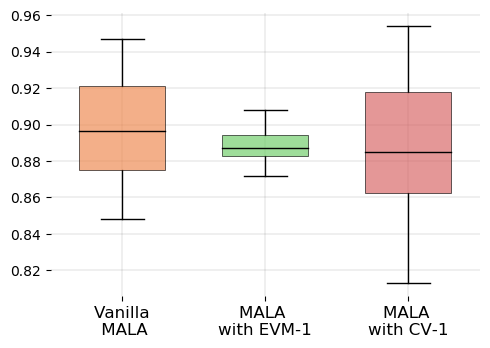

In [104]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,2]] 
boxplot_ind(data, title, labels)

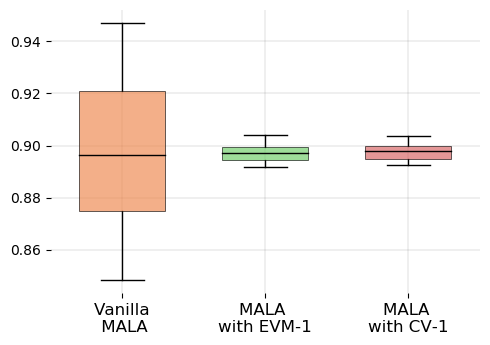

In [69]:
data = [res_arr[:,0,0],res_arr_new[:,0,2],res_arr_new[:,0,4]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['MALA \nwith EVM-1', 'MALA \nwith CV-1']

In [ ]:
data = [res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith EVM-2', 'MALA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)

In [ ]:
print(res_arr[:,0,4])

In [ ]:
title = ""
labels = ['MALA \nwith EVM-2', 'MALA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)